In [1]:
import json
import os
import pandas as pd
import numpy as np
#import ExplicitMF as mf

from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics.pairwise import linear_kernel

import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.utils import shuffle
import tensorflow as tf
from tqdm import tqdm
import re
import scipy
#from tensorflow import keras
from tensorflow.keras.layers import Input,Flatten, Embedding, Reshape, Multiply, Dropout, Dense, Concatenate, GlobalAveragePooling1D
from tensorflow.keras.layers import Layer, SpatialDropout1D, GlobalMaxPooling1D, Bidirectional, LSTM
from tensorflow.keras.layers import Dot, TimeDistributed, BatchNormalization, multiply
from tensorflow.keras import initializers, regularizers, constraints
from tensorflow.keras import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
import collections
from collections import Counter
import math

In [28]:
# the methods traverse_dir(), load_data() and the dataset are provided by supervisor Peng Liu

def traverse_dir(rootDir, level=2):
    
    dir_list = []
    print(">>>",rootDir)
    for lists in os.listdir(rootDir):
        path = os.path.join(rootDir, lists)
        if level == 1:
            dir_list.append(path)
        else:
            if os.path.isdir(path):
                temp_list = traverse_dir(path, level)
                dir_list.extend(temp_list)
            else:
                dir_list.append(path)
    return dir_list

def load_data(rootpath, flist):
    """
        Load events from files and convert to dataframe.
    """
    map_lst = []
    for fname in flist:
        #fname = os.path.join(rootpath, f)
        for line in open(fname):
            obj = json.loads(line.strip())
            if not obj is None:
                map_lst.append(obj)
    return pd.DataFrame(map_lst)


In [29]:
fpath="./active1000/"
flist = traverse_dir(fpath)
df = load_data(fpath, flist)

>>> ./active1000/


# 1. Preprocessing

In [30]:
df.head(1)

,eventId,category,activeTime,title,url,userId,publishtime,time,documentId
0,1452187460,None,NaN,None,http://adressa.no,cx:i6cniurf675smd1y:hp3ao3akzuqt,None,1490050819,None


In [32]:
print(len(df))
df = df[df["documentId"].notna()][:5000]
print(len(df))
df = df[df.groupby('userId').userId.transform('count')>2].copy()
print(len(df))
user_enc = LabelEncoder()
article_enc = LabelEncoder()
df["user_id"] = user_enc.fit_transform(df["userId"].values)
df["article_id"] = article_enc.fit_transform(df["documentId"].values)

5000
5000
4726


In [33]:
def take_one_category(text):
    """
    Convert hyphen to underline for the subcategories. So that Tfidf works correctly
    """
    try:
        cat = text.split("|")
        if len(cat) > 1:
            return cat[1]
        return cat
    except:
        return "null"
#behaviors = clean_title(behaviors)
df["category_cleaned"] = df["category"].apply(func = take_one_category)

In [34]:
category_enc = LabelEncoder()
df["category_int"] = category_enc.fit_transform(df["category_cleaned"].values)


In [35]:
def get_userid_to_profile(df):
    users = df["user_id"].unique()
    userid_to_profile = collections.defaultdict(list)
    for user_id in tqdm(users):
        user_subcat = df[df["user_id"] == user_id]["category_int"].values.tolist()
        counter = Counter(user_subcat)
        s = sorted(user_subcat, key=lambda x: (counter[x], x), reverse=True)
        final_subcategories = []
        for elem in s:
            if elem not in final_subcategories:
                final_subcategories.append(elem)
        while len(final_subcategories) < 6:
            final_subcategories.append(0)
        userid_to_profile[user_id] = final_subcategories[:6]
    return userid_to_profile
userid_to_profile = get_userid_to_profile(df)

100%|██████████| 598/598 [00:00<00:00, 1894.88it/s]


# 2. Train test split

In [36]:
SEED = 42
SAMPLE_SIZE = 99
NUM_NEGATIVES = 4
ALL_ARTICLE_IDS = df["article_id"].unique()
NUM_ARTICLES = len(ALL_ARTICLE_IDS)
ALL_USERS = df["user_id"].unique()
NUM_USERS = len(ALL_USERS)
NUM_CATEGORIES = len(df["category_int"].unique())
DIMS=20

### Global dicts ###
    #userid_to_profile
    #userid_to_click_history

In [37]:
df["rank_latest"] = df.groupby(["user_id"])["time"].rank(method="first", ascending=False)

train_true = df[df['rank_latest'] != 1]
test_true = df[df['rank_latest'] == 1]

rating = [1 for i in range(len(train_true))]
train_true["label"] = rating

train = train_true[["user_id", "article_id", "label"]]
test = test_true[["user_id", "article_id"]]

/Users/eivindfalun/opt/anaconda3/envs/shapRs/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [38]:
def get_userid_to_click_history(df):
    userid_to_article_history = {}
    for user_id in tqdm(df["user_id"].unique()):
        click_history = df[df["user_id"] == user_id]["article_id"].values
        if len(click_history) < 10:
            while len(click_history) < 10:
                click_history = np.append(click_history, 0)
        if len(click_history) > 10:
            click_history = click_history[:10]
        userid_to_article_history[user_id] = click_history
    return userid_to_article_history
userid_to_click_history = get_userid_to_click_history(train_true)

100%|██████████| 598/598 [00:00<00:00, 1801.58it/s]


In [39]:
train_true[train_true["user_id"]==127]

,eventId,category,activeTime,title,url,userId,publishtime,time,documentId,user_id,article_id,category_cleaned,category_int,rank_latest,label
3179,1851351593,nyheter|nordtrondelag,18.0,Unormalt røntgenbilde ble ikke fulgt opp - 14-...,http://adressa.no/nyheter/nordtrondelag/2017/0...,cx:1mbgezqbg3t0e1y066ytii2bad:3j3b1qv82lth4,2017-03-21T06:12:46.000Z,1490078330,2b44f8c808720ecf63b9b80a0e547dc9566dde74,127,75,nordtrondelag,12,9.0,1
3218,2031390276,nyheter|sortrondelag,NaN,"Fant skjelett, trolig fra istida",http://adressa.no/nyheter/sortrondelag/2017/03...,cx:1mbgezqbg3t0e1y066ytii2bad:3j3b1qv82lth4,2017-03-19T21:08:58.000Z,1490078368,393cf82375d145db74f8d35fdac31ce94293913e,127,105,sortrondelag,18,8.0,1
5287,135036125,pluss|sport,NaN,Se hele topp 100-lista,http://adressa.no/pluss/sport/2017/03/07/rbks-...,cx:1mbgezqbg3t0e1y066ytii2bad:3j3b1qv82lth4,2017-03-07T08:12:10.000Z,1490083104,c557d56d63822d751abed796e0b6285842caa579,127,302,sport,19,7.0,1
7634,86548573,pluss|magasin,34.0,Snart må alle i Trondheim endre søppelvanene sine,http://adressa.no/pluss/magasin/2017/03/18/sli...,cx:1mbgezqbg3t0e1y066ytii2bad:3j3b1qv82lth4,2017-03-18T09:12:48.000Z,1490089175,2bd33f99074edd1262e6ce9c1b11b4fb9468115e,127,78,magasin,9,6.0,1
7649,485060606,nyheter|trondheim,26.0,- Viktig med en avklaring om det er lovstridig,http://adressa.no/nyheter/trondheim/2017/03/21...,cx:1mbgezqbg3t0e1y066ytii2bad:3j3b1qv82lth4,2017-03-21T06:37:49.000Z,1490089229,2841bd062456f1357c181ba7af01c60c1ed61602,127,69,trondheim,22,5.0,1
7672,1380867229,pluss|nyheter,NaN,Sjekk ruter og holdeplasser i vårt nye superbu...,http://adressa.no/pluss/nyheter/2017/03/20/sje...,cx:1mbgezqbg3t0e1y066ytii2bad:3j3b1qv82lth4,2017-03-20T12:15:19.000Z,1490089299,a86a943918c5f73f4f9afd5f449afa2d17f63ef6,127,270,nyheter,14,4.0,1
9172,1810064393,nyheter|trondheim,18.0,Vil ikke ha flere vannscootere i Trondheimheim...,http://adressa.no/nyheter/trondheim/2017/03/21...,cx:1mbgezqbg3t0e1y066ytii2bad:3j3b1qv82lth4,2017-03-21T10:57:32.000Z,1490094430,67ba44a662b89659886c3058707c85022fe18b96,127,181,trondheim,22,3.0,1
9187,948423005,100sport|ballsport,13.0,Talentet har kontrakt med Byåsen – får gå grat...,http://adressa.no/100sport/ballsport/-talentet...,cx:1mbgezqbg3t0e1y066ytii2bad:3j3b1qv82lth4,2017-03-21T09:34:26.000Z,1490094470,d1d0f675b2f9c81cd85b5fd3a8cc0640851ee173,127,318,ballsport,1,2.0,1


In [40]:
test[test["user_id"]==127]

,user_id,article_id
9203,127,303


In [41]:
def get_category(article_id, df=df):  
    return df[df["article_id"] == article_id]["category_int"].values[0]

In [42]:
def get_items_interacted(user_id, df):
    interacted_items = df[df["user_id"]==user_id]["article_id"]
    return set(interacted_items if type(interacted_items) == pd.Series else [interacted_items])

def get_not_interacted(user_id, interactions_df=df):
    interacted_items = get_items_interacted(user_id, interactions_df)
    all_items = set(df["article_id"])
    not_interacted_items = all_items - interacted_items
    random.seed(SEED)
    not_interacted_items = random.sample(not_interacted_items, SAMPLE_SIZE)
    return not_interacted_items

In [43]:
article_to_category = df[["article_id", "category_int"]].set_index("article_id").to_dict()["category_int"]

In [44]:
def negative_sampling(train_df, user_id, article_id):
    """
    Negative sample training instance; for each positive instance, add 4 negative articles
    
    Return user_ids, news_ids, category_1, category_2, authors_onehotencoded, titles
    """
    
    users, articles, categories, click_history, profiles, labels = [], [], [], [], [], []
    user_item_set = set(zip(train_df[user_id].values, train_df[article_id].values))
    for (u,i) in user_item_set:
        for _ in range(NUM_NEGATIVES):
            negative_item = np.random.choice(ALL_ARTICLE_IDS)
            while (u, negative_item) in user_item_set:
                negative_item = np.random.choice(ALL_ARTICLE_IDS)
            users.append(u)
            articles.append(negative_item)
            categories.append(article_to_category[negative_item])
            click_history.append(userid_to_click_history[u])
            profiles.append(userid_to_profile[u])
            labels.append(0)
        users.append(u)
        articles.append(i)
        categories.append(article_to_category[i])
        click_history.append(userid_to_click_history[u])
        profiles.append(userid_to_profile[u])
        labels.append(1)
    
    users, articles,categories,click_history,profiles, labels = shuffle(users, articles,categories,click_history,profiles, labels, random_state=0)
    click_history = np.concatenate(click_history).reshape(-1, 10)
    profiles = np.concatenate(profiles).reshape(-1,6)
    return users, articles,categories,click_history,profiles, labels

train_users, train_articles,train_categories,train_click_history,train_profiles, train_labels = negative_sampling(train, "user_id", "article_id")

In [45]:
df_train = pd.DataFrame(list(zip(train_users, train_articles,train_categories,train_click_history,train_profiles, train_labels)),
                       columns=["user_id", "article_id", "category", "click_history", "user_profile", "label"])

# 4 Models

In [114]:
def get_category_hit_ratio(user_profile, top_ten_categories):
    num_hits = 0
    for profile in user_profile:
        for category in top_ten_categories:
            if profile == category:
                num_hits+= 1
    
    return num_hits
def get_ndcgs_category(user_profile, top_ten_categories):
    for i in range(len(top_ten_categories)):
        item = top_ten_categories[i]
        for profile in user_profile:
            if item == profile:
                return math.log(2) / math.log(i+2)
    return 0

In [117]:
def getHitRatio(ranklist, gtItem):
    for item in ranklist:
        if item == gtItem:
            return 1
    return 0

def getNDCG(ranklist, gtItem):
    for i in range(len(ranklist)):
        item = ranklist[i]
        if item == gtItem:
            return math.log(2) / math.log(i+2)
    return 0

# 4.1 Poposed method

In [46]:
def get_model( dense_layers=[128, 64, 32, 8]):
    #User features
    user_history = Input(shape=(10,), name="user")
    user_profile_input = Input(shape=(6,), name="profile")
    #item features
    item_input = Input(shape=(1,), name="item")
    item_category = Input(shape=(1,), name="category")
    item_subcategory = Input(shape=(1,), name="subcategory")
    
    # User emb
    click_history_emb = Embedding(output_dim=DIMS, 
                                  input_dim=NUM_ARTICLES, 
                                  input_length=10,
                                  embeddings_initializer='he_normal', 
                                  embeddings_regularizer=regularizers.l2(0.001), 
                                  name="mf_user_emb")(user_history)
    profile_emb = Embedding(output_dim=DIMS, 
                            input_dim=NUM_CATEGORIES, 
                            input_length=6, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_profile_emb")(user_profile_input)
    
    # Item emb
    item_emb = Embedding(output_dim=DIMS, 
                         input_dim=NUM_ARTICLES, 
                         input_length=1,
                         embeddings_initializer='he_normal', 
                         embeddings_regularizer=regularizers.l2(0.001), 
                         name="mf_item_emb")(item_input)
    category_emb = Embedding(output_dim=DIMS, 
                             input_dim=NUM_CATEGORIES, 
                             input_length=1,
                             embeddings_initializer='he_normal', 
                             embeddings_regularizer=regularizers.l2(0.001),
                             name="cat_emb")(item_category)
    
    ### Wide
    #wide_history = Flatten()(click_history_emb)
    #wide_item = Flatten()(item_input)
    wide = Concatenate(axis=1)([click_history_emb, item_emb])
    wide = Flatten()(wide)
    y_wide = Dense(2)(wide)
    
    ### Deep
    deep_features = Concatenate(axis=1)([category_emb, profile_emb])
    x_deep = LSTM(40)(deep_features)
    
    print(x_deep.shape)
    print(y_wide.shape)
    
    final = Concatenate()([x_deep, y_wide])
    final = BatchNormalization(axis=1)(final)
   
    y = Dense(1, activation="sigmoid")(final)
    
    
    model = Model(inputs=[user_history, user_profile_input, item_input, item_category], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_final = get_model()

(None, 40)
(None, 2)


In [47]:
users_input, articles_input, labels_input = np.array(train_users).reshape(-1,1), np.array(train_articles).reshape(-1,1), np.array(train_labels).reshape(-1,1)
categories_input = np.array(train_categories).reshape(-1,1)


In [48]:
#train_users, train_articles,train_categories,train_click_history,train_profiles, train_labels
#user_id_input, user_profile_input, item_id_input, item_category_input
train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0
best_hits_five = 0
best_ndcgs_five = 0

epochs=4
for epoch in range(epochs):
    hist = model_final.fit([train_click_history, train_profiles, articles_input, categories_input], labels_input, epochs=1, shuffle=True, verbose=1, batch_size=1024)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])

18/18 [==============================] - 0s 19ms/step - loss: 0.3092 - accuracy: 0.8847


In [118]:
test_users = test.user_id.values
test_items = test.article_id.values
test_users, test_items = shuffle(test_users, test_items)
test_users, test_items = test_users[:100], test_items[:100]
test_set = zip(test_users, test_items)
hits_ten,hits_five,ndcgs_ten,ndcgs_five = [], [], [], []
h_ten, h_five, n_ten, n_five = [], [], [], []
for (u,i) in tqdm(test_set):
    not_interacted_items = get_not_interacted(u)
    users = np.array([u]*100)
    items = np.array([i]+not_interacted_items)
    profiles = np.tile(np.array(userid_to_profile[u]), 100).reshape(-1, 6)
    categories = np.tile(np.array(article_to_category[i]), 100).reshape(-1,1)
    click_history = np.tile(userid_to_click_history[u], 100).reshape(-1,10)
    
    predictions = model_final.predict([click_history,profiles, items,categories])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [items[k] for k in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    # ###
    top_ten_categories = []
    user_profile = userid_to_profile[u]
    for rec_item in top_ten_items:
        top_ten_categories.append(article_to_category[rec_item])
        
    hits_ten.append(get_category_hit_ratio(user_profile, top_ten_categories))
    hits_five.append(get_category_hit_ratio(user_profile, top_ten_categories[:5]))
    ndcgs_ten.append(get_ndcgs_category(user_profile, top_ten_categories))
    ndcgs_five.append(get_ndcgs_category(user_profile, top_ten_categories[:5]))
    
    h_ten.append(getHitRatio(top_ten_items, i))
    h_five.append(getHitRatio(top_ten_items[:5], i))
    n_ten.append(getNDCG(top_ten_items, i))
    n_five.append(getNDCG(top_ten_items[:5], i))



100it [00:04, 22.35it/s]


In [119]:
print(np.average(hits_ten))
print(np.average(hits_five))
print(np.average(ndcgs_ten))
print(np.average(ndcgs_five))

print("\n")
print(np.average(h_ten))
print(np.average(h_five))
print(np.average(n_ten))
print(np.average(n_five))

4.24
1.9
0.7363271431794394
0.7091529454650081


0.81
0.63
0.5260749455314282
0.46601326534796716


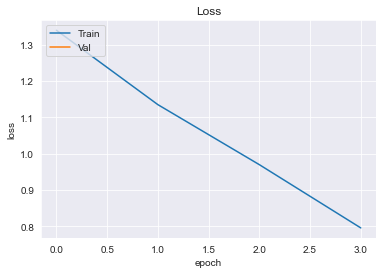

In [109]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc4_loss.pdf")
plt.show()

# 4.2 Arc 1

In [55]:
#@tf.autograph.experimental.do_not_convert
def get_model_ncf(dense_layers=[128, 64, 32, 8]):
    user_input = Input(shape=(1,), name="user")
    item_input = Input(shape=(1,), name="item")
    
    user_emb = Embedding(output_dim=DIMS, 
                         input_dim=NUM_USERS, 
                         input_length=1,
                         embeddings_initializer='he_normal', 
                         embeddings_regularizer=regularizers.l2(0.001),
                         name="mf_user_emb")(user_input)
    item_emb = Embedding(output_dim=DIMS, 
                         input_dim=NUM_ARTICLES, 
                         input_length=1,
                         embeddings_initializer='he_normal', 
                         embeddings_regularizer=regularizers.l2(0.001),
                         name="mf_item_emb")(item_input)
    
    user_vecs = Flatten()(user_emb)
    item_vecs = Flatten()(item_emb)
    
    #y = Multiply()([user_vecs, item_vecs])
    y = Dot(1, normalize=False)([user_vecs, item_vecs])
    
    y = Dense(1, activation="sigmoid")(y)
    
    
    model = Model(inputs=[user_input, item_input], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="mse",
        metrics=["accuracy"],
    )
    return model

model_arc1 = get_model_ncf()

In [ ]:
users_input, articles_input, labels_input = np.array(train_users).reshape(-1,1), np.array(train_articles).reshape(-1,1), np.array(train_labels).reshape(-1,1)

In [56]:
all_user_ids = train.index.unique().values

#user_input = df_train.iloc[:, 0].values.reshape((-1,1))
#profile_input = df_train.iloc[:, 1:6].values
#item_input = df_train.iloc[:, 7].values.reshape((-1,1))
#labels = df_train.iloc[:, 8].values.reshape((-1,1))


train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0
best_hits_five = 0
best_ndcgs_five = 0

epochs=4
for epoch in range(epochs):
    hist = model_arc1.fit([users_input, articles_input], labels_input, epochs=1, shuffle=True, verbose=1, batch_size=1024)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])
    #val_loss.append(hist.history["val_loss"])
    #val_acc.append(hist.history["val_accuracy"])
    
    #hits, ndcgs, hits_five, ndcgs_five = evalaute_model_neumf( model_neumf, df_test, userid_to_true_item)
    #hits_list.append(np.average(hits))
    #ndcg_list.append(np.average(ndcgs))
    
    #temp_hits = np.average(hits)
    #temp_ndcgs = np.average(ndcgs)
    #if (temp_hits > best_hits):
    #    best_hits = temp_hits
    #    best_ndcgs = temp_ndcgs
    #    best_hits_five = np.average(hits_five)
    #    best_ndcgs_five = np.average(ndcgs_five)

18/18 [==============================] - 0s 2ms/step - loss: 0.1863 - accuracy: 0.8000


In [58]:

test_users = test.user_id.values
test_items = test.article_id.values
test_users, test_items = shuffle(test_users, test_items)
test_users, test_items = test_users[:100], test_items[:100]
test_set = zip(test_users, test_items)
hits_ten,hits_five,ndcgs_ten,ndcgs_five = [], [], [], []
for (u,i) in tqdm(test_set):
    not_interacted_items = get_not_interacted(u)
    users = np.array([u]*100)
    items = np.array([i]+not_interacted_items)
    predictions = model_arc1.predict([users, items])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [items[k] for k in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    ###
    top_ten_categories = []
    user_profile = userid_to_profile[u]
    for rec_item in top_ten_items:
        top_ten_categories.append(article_to_category[rec_item])
        
    hits_ten.append(get_category_hit_ratio(user_profile, top_ten_categories))
    hits_five.append(get_category_hit_ratio(user_profile, top_ten_categories[:5]))
    ndcgs_ten.append(get_ndcgs_category(user_profile, top_ten_categories))
    ndcgs_five.append(get_ndcgs_category(user_profile, top_ten_categories[:5]))

100it [00:03, 28.11it/s]


In [106]:
print(np.average(hits_ten))
print(np.average(hits_five))
print(np.average(ndcgs_ten))
print(np.average(ndcgs_five))

4.54
2.44
0.7373402188236722
0.7245086034325083


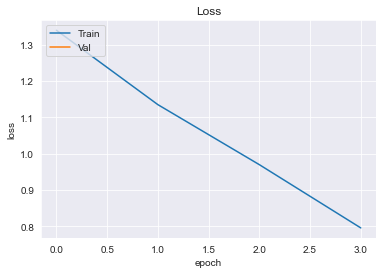

In [107]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc4_loss.pdf")
plt.show()

# 4.2 Arch 3 - Wide and deep with features

In [100]:
def get_model_wide( dense_layers=[128, 64, 32, 8]):
    #### Matrix factorization ####
    user_id_input = Input(shape=[1], name="user_id")
    item_id_input = Input(shape=[1], name="item_id")
    user_embedding = Embedding(input_dim=NUM_USERS, 
                               output_dim=DIMS, 
                               input_length=1, 
                               embeddings_initializer='he_normal', 
                               embeddings_regularizer=regularizers.l2(0.001),
                               name="user_embedding")(user_id_input)
    item_embedding = Embedding(input_dim=NUM_ARTICLES, 
                               output_dim=DIMS, 
                               embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                               name="item_embedding")(item_id_input)
    
    user_flatten = Flatten()(user_embedding)
    item_flatten = Flatten()(item_embedding)
    mf_vec = Concatenate()([user_flatten, item_flatten])
    
    x_deep = Dense(128, activation="relu", kernel_initializer='he_uniform',kernel_regularizer=regularizers.l2(0.001))(mf_vec)
    x_deep = Dropout(0.2)(x_deep)
    x_deep = Dense(64, activation="relu",kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001))(x_deep)
    x_deep = Dropout(0.2)(x_deep)
    
    #### Wide part ####
    
    user_profile_input = Input(shape=(6,), name="user_profile")
    item_category_input = Input(shape=(1,), name="category_input")
    
    item_category_emb = Embedding(input_dim=NUM_CATEGORIES, output_dim=DIMS, name="category_emd", embeddings_regularizer=regularizers.l2(0.001))(item_category_input)
    user_profile_emb = Embedding(input_dim=NUM_CATEGORIES, output_dim=DIMS,embeddings_regularizer=regularizers.l2(0.001), name="profile_emb")(user_profile_input)

    item_category_flatten = Flatten()(item_category_emb)
    user_profile_flatten = Flatten()(user_profile_emb)
    
    wide_features = Concatenate()([item_category_flatten,  user_profile_flatten])
    
    x_wide = Dense(128, activation="relu",kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001))(wide_features)
    x_wide = Dropout(0.5)(x_wide)
    x_wide = Dense(64, activation="relu",kernel_initializer='he_uniform', kernel_regularizer=regularizers.l2(0.001))(x_wide)
    x_wide = Dropout(0.5)(x_wide)
    
    final = Concatenate()([x_deep,x_wide])
    x = Dense(128, kernel_initializer='he_uniform',activation="relu")(final)
    x = Dropout(0.5)(x)
    y = Dense(1, activation="sigmoid")(x)
    
    
    model = Model(inputs=[user_id_input, user_profile_input, item_id_input, item_category_input], outputs=y)
    model.compile(
        optimizer=Adam(0.001),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_wide = get_model_wide()

In [101]:
users_input, articles_input, labels_input = np.array(train_users).reshape(-1,1), np.array(train_articles).reshape(-1,1), np.array(train_labels).reshape(-1,1)
categories_input = np.array(train_categories).reshape(-1,1)

In [103]:
#users_input, train_profiles, articles_input, categories_input
train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0
best_hits_five = 0
best_ndcgs_five = 0

epochs=4
for epoch in range(epochs):
    hist = model_wide.fit([users_input, train_profiles, articles_input, categories_input], labels_input, epochs=1, shuffle=True, verbose=1, batch_size=1024)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])

18/18 [==============================] - 0s 9ms/step - loss: 0.7954 - accuracy: 0.8026


In [104]:
test_users = test.user_id.values
test_items = test.article_id.values
test_users, test_items = shuffle(test_users, test_items)
test_users, test_items = test_users[:100], test_items[:100]
test_set = zip(test_users, test_items)
hits_ten,hits_five,ndcgs_ten,ndcgs_five = [], [], [], []
for (u,i) in tqdm(test_set):
    not_interacted_items = get_not_interacted(u)
    users = np.array([u]*100)
    items = np.array([i]+not_interacted_items)
    profiles = np.tile(np.array(userid_to_profile[u]), 100).reshape(-1, 6)
    categories = np.tile(np.array(article_to_category[i]), 100).reshape(-1,1)
    click_history = np.tile(userid_to_click_history[u], 100).reshape(-1,10)

    predictions = model_wide.predict([users,profiles, items,categories])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [items[k] for k in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    ###
    top_ten_categories = []
    user_profile = userid_to_profile[u]
    for rec_item in top_ten_items:
        top_ten_categories.append(article_to_category[rec_item])
        
    hits_ten.append(get_category_hit_ratio(user_profile, top_ten_categories))
    hits_five.append(get_category_hit_ratio(user_profile, top_ten_categories[:5]))
    ndcgs_ten.append(get_ndcgs_category(user_profile, top_ten_categories))
    ndcgs_five.append(get_ndcgs_category(user_profile, top_ten_categories[:5]))

100it [00:04, 20.71it/s]


In [110]:
print(np.average(hits_ten))
print(np.average(hits_five))
print(np.average(ndcgs_ten))
print(np.average(ndcgs_five))

4.54
2.44
0.7373402188236722
0.7245086034325083


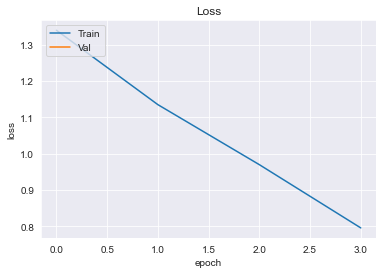

In [111]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc4_loss.pdf")
plt.show()

# 4.3 Arch 2 - NeuMF with features

In [67]:

def get_model_neumffeatures( dense_layers=[128, 64, 32, 8]):
    user_input = Input(shape=(1,), name="user_input")
    item_input = Input(shape=(1,), name="item")
    user_history = Input(shape=(10,), name="user")
    user_profile_input = Input(shape=(6,), name="profile")
    #item features
    item_category = Input(shape=(1,), name="category")
    
    
    mf_user_emb = Embedding(output_dim=DIMS, 
                            input_dim=NUM_USERS, 
                            input_length=1, 
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_user_emb")(user_input)
    mf_item_emb = Embedding(output_dim=DIMS, 
                            input_dim=NUM_ARTICLES,
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            input_length=1, name="mf_item_emb")(item_input)
    
    num_layers = len(dense_layers)
    
    
    
    
    # User emb
    mlp_click_history_emb = Embedding(output_dim=int(dense_layers[0] / 2), input_dim=NUM_ARTICLES, input_length=10, name="mlp_user_emb")(user_history)
    mlp_profile_emb = Embedding(output_dim=int(dense_layers[0] / 2), input_dim=NUM_CATEGORIES, input_length=6, name="mlp_profile_emb")(user_profile_input)
    
    # Item emb
    mlp_item_emb = Embedding(output_dim=int(dense_layers[0] / 2), input_dim=NUM_ARTICLES, input_length=1, name="mlp_item_emb")(item_input)
    mlp_category_emb = Embedding(output_dim=int(dense_layers[0] / 2), input_dim=NUM_CATEGORIES, input_length=1, name="cat_emb")(item_category)
    
    ### Wide
    wide = Concatenate(axis=1)([mlp_click_history_emb,mlp_profile_emb,mlp_item_emb,mlp_category_emb ])
    mlp_vector = Flatten()(wide)
    
    # Matrix factorization
    mf_user_vecs = Flatten()(mf_user_emb)
    mf_item_vecs = Flatten()(mf_item_emb)
    mf_vec = multiply([mf_user_vecs, mf_item_vecs])
    
    
    for num_nodes in dense_layers:
        l = Dense(num_nodes, activation="relu")
        mlp_vector = l(mlp_vector)
    
    y = Concatenate()([mf_vec, mlp_vector])
    y = Dense(1, activation="sigmoid", name="pred")(y)
    
    
    model = Model(inputs=[user_input,user_history, user_profile_input, item_input,item_category], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_neumffeatures = get_model_neumffeatures()

In [68]:
users_input, articles_input, labels_input = np.array(train_users).reshape(-1,1), np.array(train_articles).reshape(-1,1), np.array(train_labels).reshape(-1,1)
categories_input = np.array(train_categories).reshape(-1,1)

In [69]:
#users_input, train_profiles, articles_input, categories_input
train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0
best_hits_five = 0
best_ndcgs_five = 0

epochs=4
for epoch in range(epochs):
    hist = model_neumffeatures.fit([users_input,train_click_history, train_profiles, articles_input, categories_input], labels_input, epochs=1, shuffle=True, verbose=1, batch_size=1024)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])

18/18 [==============================] - 0s 11ms/step - loss: 0.2584 - accuracy: 0.8895


In [72]:
test_users = test.user_id.values
test_items = test.article_id.values
test_users, test_items = shuffle(test_users, test_items)
test_users, test_items = test_users[:100], test_items[:100]
test_set = zip(test_users, test_items)
hits_ten,hits_five,ndcgs_ten,ndcgs_five = [], [], [], []
for (u,i) in tqdm(test_set):
    not_interacted_items = get_not_interacted(u)
    users = np.array([u]*100)
    items = np.array([i]+not_interacted_items)
    profiles = np.tile(np.array(userid_to_profile[u]), 100).reshape(-1, 6)
    categories = np.tile(np.array(article_to_category[i]), 100).reshape(-1,1)
    click_history = np.tile(userid_to_click_history[u], 100).reshape(-1,10)

    predictions = model_neumffeatures.predict([users,click_history,profiles, items,categories])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [items[k] for k in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    ###
    top_ten_categories = []
    user_profile = userid_to_profile[u]
    for rec_item in top_ten_items:
        top_ten_categories.append(article_to_category[rec_item])
        
    hits_ten.append(get_category_hit_ratio(user_profile, top_ten_categories))
    hits_five.append(get_category_hit_ratio(user_profile, top_ten_categories[:5]))
    ndcgs_ten.append(get_ndcgs_category(user_profile, top_ten_categories))
    ndcgs_five.append(get_ndcgs_category(user_profile, top_ten_categories[:5]))

100it [00:04, 20.06it/s]


In [112]:
print(np.average(hits_ten))
print(np.average(hits_five))
print(np.average(ndcgs_ten))
print(np.average(ndcgs_five))

4.54
2.44
0.7373402188236722
0.7245086034325083


In [ ]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc4_loss.pdf")
plt.show()

# 4.4 Arch 3

In [82]:
#@tf.autograph.experimental.do_not_convert
def get_model_arc3( dense_layers=[128, 64, 32, 8]):
    #User features
    user_history = Input(shape=(10,), name="user")
    user_profile_input = Input(shape=(6,), name="profile")
    #item features
    item_input = Input(shape=(1,), name="item")
    item_category = Input(shape=(1,), name="category")
    
    # User emb
    click_history_emb = Embedding(output_dim=DIMS, input_dim=NUM_ARTICLES, input_length=10, name="mf_user_emb")(user_history)
    profile_emb = Embedding(output_dim=DIMS, input_dim=NUM_CATEGORIES, input_length=6, name="mf_profile_emb")(user_profile_input)
    
    #user_features = Concatenate(axis=1)([click_history_emb,profile_emb])
    
    # Item emb
    item_emb = Embedding(output_dim=DIMS, input_dim=NUM_ARTICLES, input_length=1, name="mf_item_emb")(item_input)
    category_emb = Embedding(output_dim=DIMS, input_dim=NUM_CATEGORIES, input_length=1, name="cat_emb")(item_category)
    
    item_features = Concatenate(axis=1)([item_emb,category_emb, profile_emb])
    
    # User-tower
    user_lstm = LSTM(40)(click_history_emb)
    user_lstm = Dropout(0.5)(user_lstm)
    user_lstm = BatchNormalization(axis=1)(user_lstm)
    
    # Item tower
    item_dense = Flatten()(item_features)
    item_dense = Dense(128)(item_dense)
    item_dense = Dropout(0.5)(item_dense)
    item_dense = BatchNormalization(axis=1)(item_dense)
    
    # Click predictor
    final = Concatenate()([user_lstm,item_dense ])
    y = Dense(1, activation="sigmoid")(final)
    
    
    model = Model(inputs=[user_history, user_profile_input, item_input, item_category], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_arc3 = get_model_arc3()

In [83]:
users_input, articles_input, labels_input = np.array(train_users).reshape(-1,1), np.array(train_articles).reshape(-1,1), np.array(train_labels).reshape(-1,1)
categories_input = np.array(train_categories).reshape(-1,1)

In [84]:
#users_input, train_profiles, articles_input, categories_input
train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0
best_hits_five = 0
best_ndcgs_five = 0

epochs=4
for epoch in range(epochs):
    hist = model_arc3.fit([train_click_history, train_profiles, articles_input, categories_input], labels_input, epochs=1, shuffle=True, verbose=1, batch_size=1024)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])

18/18 [==============================] - 1s 34ms/step - loss: 0.2756 - accuracy: 0.8811


In [85]:
test_users = test.user_id.values
test_items = test.article_id.values
test_users, test_items = shuffle(test_users, test_items)
test_users, test_items = test_users[:100], test_items[:100]
test_set = zip(test_users, test_items)
hits_ten,hits_five,ndcgs_ten,ndcgs_five = [], [], [], []
for (u,i) in tqdm(test_set):
    not_interacted_items = get_not_interacted(u)
    users = np.array([u]*100)
    items = np.array([i]+not_interacted_items)
    profiles = np.tile(np.array(userid_to_profile[u]), 100).reshape(-1, 6)
    categories = np.tile(np.array(article_to_category[i]), 100).reshape(-1,1)
    click_history = np.tile(userid_to_click_history[u], 100).reshape(-1,10)

    predictions = model_arc3.predict([click_history,profiles, items,categories])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [items[k] for k in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    ###
    top_ten_categories = []
    user_profile = userid_to_profile[u]
    for rec_item in top_ten_items:
        top_ten_categories.append(article_to_category[rec_item])
        
    hits_ten.append(get_category_hit_ratio(user_profile, top_ten_categories))
    hits_five.append(get_category_hit_ratio(user_profile, top_ten_categories[:5]))
    ndcgs_ten.append(get_ndcgs_category(user_profile, top_ten_categories))
    ndcgs_five.append(get_ndcgs_category(user_profile, top_ten_categories[:5]))

100it [00:05, 18.89it/s]


In [113]:
print(np.average(hits_ten))
print(np.average(hits_five))
print(np.average(ndcgs_ten))
print(np.average(ndcgs_five))

4.54
2.44
0.7373402188236722
0.7245086034325083


In [ ]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc4_loss.pdf")
plt.show()

# 4.5 Arch 6

In [92]:
#@tf.autograph.experimental.do_not_convert
def get_model_arc6(dense_layers=[128, 64, 32, 8]):
    #User features
    user_history = Input(shape=(10,), name="user")
    user_profile_input = Input(shape=(6,), name="profile")
    #item features
    item_input = Input(shape=(1,), name="item")
    item_category = Input(shape=(1,), name="category")
    
    # User emb
    click_history_emb = Embedding(output_dim=DIMS, 
                                  input_dim=NUM_ARTICLES, 
                                  input_length=10, 
                                  embeddings_initializer='he_normal', 
                                  embeddings_regularizer=regularizers.l2(0.001),
                                  name="mf_user_emb")(user_history)
    profile_emb = Embedding(output_dim=DIMS, 
                            input_dim=NUM_CATEGORIES, 
                            input_length=6,
                            embeddings_initializer='he_normal', 
                            embeddings_regularizer=regularizers.l2(0.001),
                            name="mf_profile_emb")(user_profile_input)
    
    # Item emb
    item_emb = Embedding(output_dim=DIMS, 
                         input_dim=NUM_ARTICLES, 
                         input_length=1,
                         embeddings_initializer='he_normal', 
                         embeddings_regularizer=regularizers.l2(0.001),
                         name="mf_item_emb")(item_input)
    category_emb = Embedding(output_dim=DIMS, 
                             input_dim=NUM_CATEGORIES, 
                             input_length=1,
                             embeddings_initializer='he_normal', 
                             embeddings_regularizer=regularizers.l2(0.001),
                             name="cat_emb")(item_category)
    
    
    
    lstm_tower_1 = profile_emb
    lstm_tower_2 = click_history_emb
    lstm_tower_1 = LSTM(40)(lstm_tower_1)
    lstm_tower_1 = Dropout(0.8)(lstm_tower_1)
    lstm_tower_1 = BatchNormalization(axis=1)(lstm_tower_1)
    #lstm_vec = BatchNormalization(axis=1)(lstm_tower_1)
    
    lstm_tower_2 = LSTM(40)(lstm_tower_2)
    lstm_tower_2 = Dropout(0.8)(lstm_tower_2)
    lstm_tower_2 = BatchNormalization(axis=1)(lstm_tower_2)
    lstm_vec = Concatenate(axis=1)([lstm_tower_1, lstm_tower_2])
    
    # MLP tower
    item_vec = Flatten()(item_emb)
    cat_vec = Flatten()(category_emb)
    mlp_tower = Concatenate(axis=1)([item_vec,cat_vec])

    mlp_tower = Dense(8)(mlp_tower)
    mlp_tower = Dropout(0.5)(mlp_tower)
    mlp_tower = BatchNormalization(axis=1)(mlp_tower)
    
    mlp_tower = Dense(2)(mlp_tower)
    mlp_tower = Dropout(0.2)(mlp_tower)
    mlp_tower = BatchNormalization(axis=1)(mlp_tower)
    
    
    # Click predictor
    final = Concatenate()([lstm_vec,mlp_tower ])
    final = BatchNormalization(axis=1)(final)
    y = Dense(1, activation="sigmoid")(final)
    
    
    model = Model(inputs=[user_history, user_profile_input, item_input, item_category], outputs=y)
    model.compile(
        optimizer=Adam(0.01),
        loss="binary_crossentropy",
        metrics=["accuracy"],
    )
    return model

model_arc6 = get_model_arc6()

In [93]:
users_input, articles_input, labels_input = np.array(train_users).reshape(-1,1), np.array(train_articles).reshape(-1,1), np.array(train_labels).reshape(-1,1)
categories_input = np.array(train_categories).reshape(-1,1)

In [94]:
#users_input, train_profiles, articles_input, categories_input
train_loss = []
val_loss = []
train_acc = []
val_acc = []

hits_list = []
ndcg_list = []
best_hits = 0
best_ndcgs = 0
best_hits_five = 0
best_ndcgs_five = 0

epochs=4
for epoch in range(epochs):
    hist = model_arc6.fit([train_click_history, train_profiles, articles_input, categories_input], labels_input, epochs=1, shuffle=True, verbose=1, batch_size=1024)
    
    train_loss.append(hist.history["loss"])
    train_acc.append(hist.history["accuracy"])

18/18 [==============================] - 1s 35ms/step - loss: 0.3439 - accuracy: 0.8684


In [95]:
test_users = test.user_id.values
test_items = test.article_id.values
test_users, test_items = shuffle(test_users, test_items)
test_users, test_items = test_users[:100], test_items[:100]
test_set = zip(test_users, test_items)
hits_ten,hits_five,ndcgs_ten,ndcgs_five = [], [], [], []
for (u,i) in tqdm(test_set):
    not_interacted_items = get_not_interacted(u)
    users = np.array([u]*100)
    items = np.array([i]+not_interacted_items)
    profiles = np.tile(np.array(userid_to_profile[u]), 100).reshape(-1, 6)
    categories = np.tile(np.array(article_to_category[i]), 100).reshape(-1,1)
    click_history = np.tile(userid_to_click_history[u], 100).reshape(-1,10)

    predictions = model_arc3.predict([click_history,profiles, items,categories])
    predicted_labels = np.squeeze(predictions)
    top_ten_items = [items[k] for k in np.argsort(predicted_labels)[::-1][0:10].tolist()]
    
    ###
    top_ten_categories = []
    user_profile = userid_to_profile[u]
    for rec_item in top_ten_items:
        top_ten_categories.append(article_to_category[rec_item])
        
    hits_ten.append(get_category_hit_ratio(user_profile, top_ten_categories))
    hits_five.append(get_category_hit_ratio(user_profile, top_ten_categories[:5]))
    ndcgs_ten.append(get_ndcgs_category(user_profile, top_ten_categories))
    ndcgs_five.append(get_ndcgs_category(user_profile, top_ten_categories[:5]))

100it [00:04, 20.58it/s]


In [96]:
print(np.average(hits_ten))
print(np.average(hits_five))
print(np.average(ndcgs_ten))
print(np.average(ndcgs_five))

4.31
2.16
0.752821051365254
0.738572763880933


In [ ]:
sns.set_style("darkgrid")
plt.plot(train_loss)
plt.plot(val_loss)
plt.title('Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.savefig("arc4_loss.pdf")
plt.show()